In [1]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path = '/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path, 'audio_features.tsv')
path_playlists = os.path.join(path, 'playlists.tsv')
path_tracks = os.path.join(path, 'tracks.tsv')

In [3]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [4]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [5]:
pd_full.shape

(86400, 25)

In [6]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [7]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [8]:
pd_full.shape

(86350, 25)

## Baseline model

### Xác định độ quan trọng của các features?

In [9]:
nums_top = 80
pd_playlists_top = pd_playlists.copy()
pd_playlists_top = pd_playlists_top.sort_values(by = 'num_tracks', ascending=False)
pd_playlists_top = pd_playlists_top[:nums_top]
pd_playlists_top.shape

(80, 5)

In [10]:
pd_tracks_copy = pd.read_csv(path_tracks, sep = '\t')
pd_tracks_copy.head()

pd_tracks_copy = pd.merge(pd_tracks_copy, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_tracks_copy = pd_tracks_copy.drop('id', 1)

pd_full_top = pd.merge(pd_tracks_copy, pd_playlists_top, left_on = 'playlist_id', right_on = 'playlist_id')

pd_full_top = pd_full_top.drop('playlist_name_y', 1)


In [11]:
le = preprocessing.LabelEncoder()
le.fit(pd_full_top['playlist_id'])
pd_full_top['playlist_id_label'] = le.transform(pd_full_top['playlist_id'])

In [12]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'time_signature', 'description', 'num_followers', 'num_tracks']
pd_full_top = pd_full_top.drop(omit_feats, 1)

**Ý tưởng**:

Model 1: LightGBM

In [13]:
clf = lgb.LGBMClassifier(class_weight='balanced',drop_rate=0.9, min_data_in_leaf=100, max_bin=255,
                                 n_estimators=500,min_sum_hessian_in_leaf=1,importance_type='gain',learning_rate=0.1,bagging_fraction = 0.85,
                                 colsample_bytree = 1.0,feature_fraction = 0.1,lambda_l1 = 5.0,lambda_l2 = 3.0,max_depth =  9,
                                 min_child_samples = 55,min_child_weight = 5.0,min_split_gain = 0.1,num_leaves = 45,subsample = 0.75)  

X = pd_full_top.drop('playlist_id_label', 1)
y = pd_full_top['playlist_id_label']

In [14]:
clf.fit(X, y, verbose=True)

LGBMClassifier(bagging_fraction=0.85, boosting_type='gbdt',
               class_weight='balanced', colsample_bytree=1.0, drop_rate=0.9,
               feature_fraction=0.1, importance_type='gain', lambda_l1=5.0,
               lambda_l2=3.0, learning_rate=0.1, max_bin=255, max_depth=9,
               min_child_samples=55, min_child_weight=5.0, min_data_in_leaf=100,
               min_split_gain=0.1, min_sum_hessian_in_leaf=1, n_estimators=500,
               n_jobs=-1, num_leaves=45, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.75,
               subsample_for_bin=200000, subsample_freq=0)

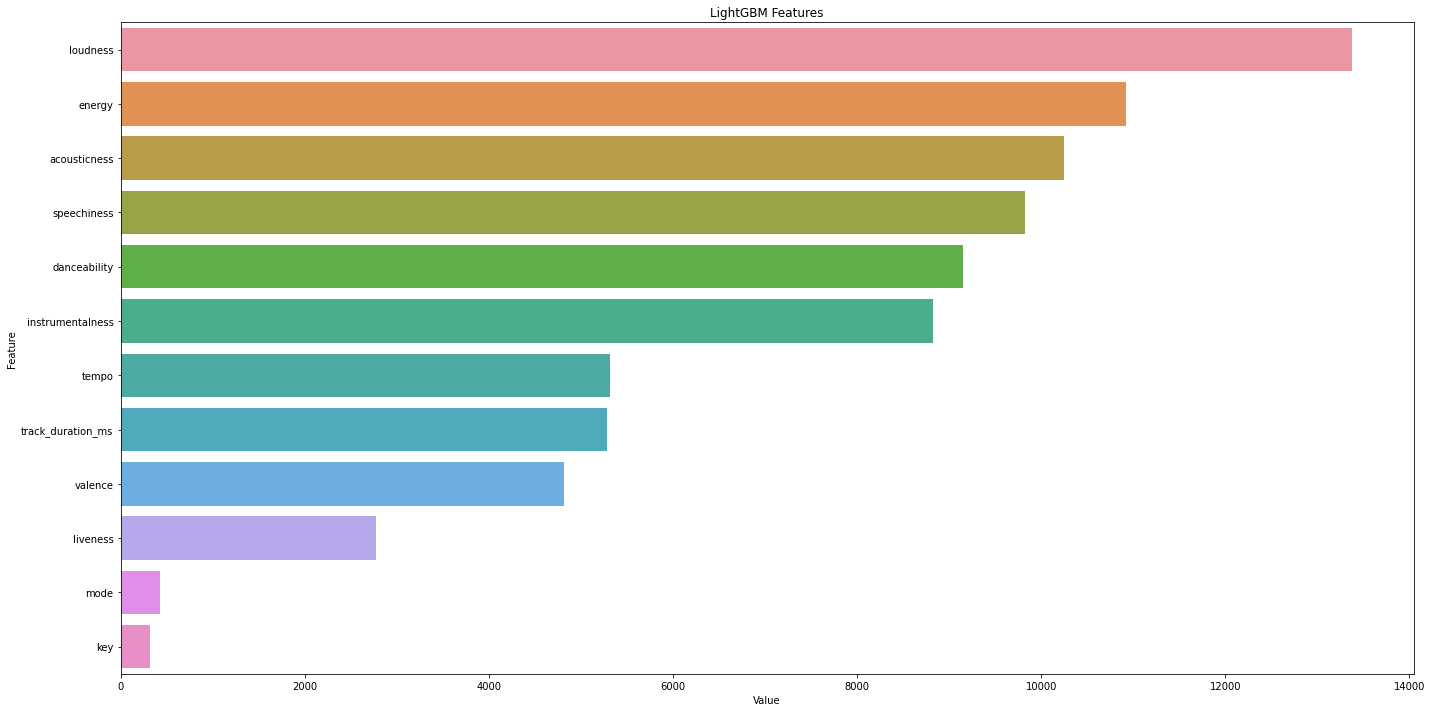

In [15]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

**Sử dụng model ExtraTreesClassifier**

In [16]:
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

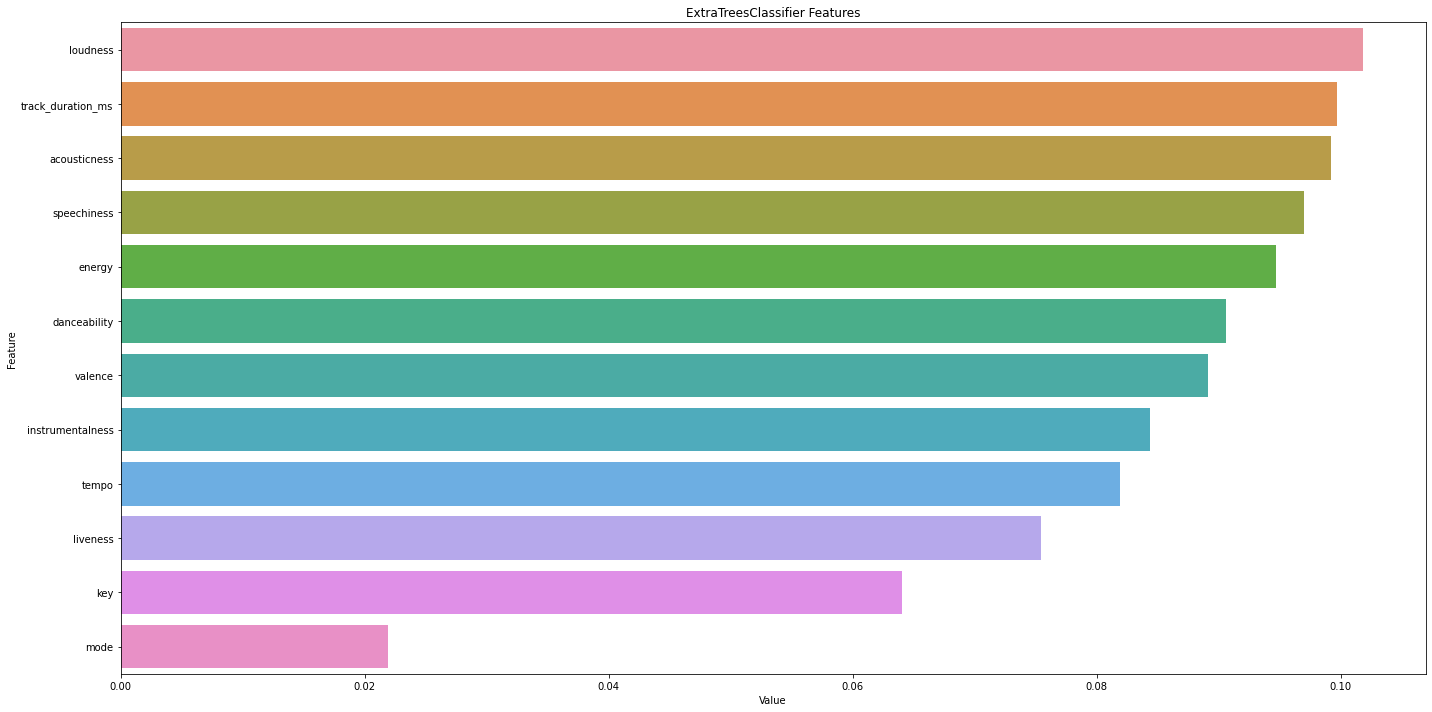

In [17]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('ExtraTreesClassifier Features')
plt.tight_layout()
plt.show()

Ở đây nhóm em quyết định sử dụng các top 4 features quan trọng nhất của mỗi model bao gồm:



## Improvement of baseline model

In [55]:
features = ['loudness', 'acousticness', 'track_duration_ms', 'speechiness', 'danceability', 'loudness', 'energy', 'danceability']

In [56]:
fraction = 3
track_id_all = generate_playlists(pd_tracks, pd_playlists)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [57]:
all_playlistID_for_tests = list(track_id_test.keys())

In [58]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]

In [59]:
def multi_feats_baseline(tracks, df, n_pred, feats):
    recs_id = []
    for t in tracks:
      sum_feat_values = 0
      for feat in feats:
        feat_values = df[df['track_id'] == t][feat]
        sum_feat_values = sum_feat_values + np.abs(df[feat] - feat_values.values[0]) ** len(feats)
      
      df['rec_df_feats'] = sum_feat_values ** (1 / len(feats))
      one_recs_id = list(df.sort_values(by=['rec_df_feats'])['track_id'][1:].values)
      recs_id.extend([track for track in one_recs_id if track not in tracks][0:n_pred])

    preds = collections.Counter(recs_id).most_common(n_pred)
    pred_titles = [p[0] for p in preds]

    tracks_name = []
    for id_track in pred_titles:
      tracks_name.extend(list(np.unique(df[df['track_id'] == id_track]['track_name'].values)))

    return pred_titles, tracks_name

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [60]:
playlists_to_test = all_playlistID_for_tests[0]

In [61]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [62]:
track_id_result, track_name_result = multi_feats_baseline(track_id_test[playlists_to_test], pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]), features)

In [63]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['101', 'The Less I Know The Better', 'The Less I Know The Better', 'Feeling Ok', 'Fire', 'Fire', 'Temporary Love', 'Mountain at My Gates', 'Fire', 'Tilted', 'Feeling Ok', 'Winterbreak', 'Our Own House', '101', 'The Less I Know The Better', 'Temporary Love', 'Mountain at My Gates', 'Mountain at My Gates', 'Never Going Home', 'Honey', 'Feeling Ok', 'Winterbreak', 'Underdressed', 'The Less I Know The Better', 'Ophelia', 'The Less I Know The Better', 'Temporary Love', 'Mountain at My Gates', 'Fire', 'Under the Sun', 'Tilted', 'Ophelia', 'Tired of Talking', 'Never Going Home', 'Honey', 'Feeling Ok', 'Winterbreak', 'Underdressed', 'All We Ever Knew', 'Our Own House', '101', 'All We Ever Knew', 'Under the Sun', 'Tilted', 'Tired of Talking', 'Ophelia', 'Our Own House', 'Our Own House'] 

Songs recommended:  ['Jonny Boy', "You're Beautiful", 'Lost Cowboys', 'What You Know Bout Love', 'Moor', 'Cruise', 'Forget Me Knots (feat. Dublin Gospel Choir)', 'XO', 'Kiss Me', 'In The Flesh? 

**Kiểm tra độ chính xác trên testcase đầu tiên**

In [64]:
track_name_result.extend(given_songs_name)

In [65]:
r_score = r_precision(track_name_result, all_name_songs)
print(f'r_score: {r_score}')

r_score: 0.32653061224489793


**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [66]:
def test_multi_feats(pd_full, track_id_all, track_id_test, all_playlistID_for_tests, features, fraction = 5):
  r_score = []

  for each_playlist in all_playlistID_for_tests:
    track_id_result, track_name_result = multi_feats_baseline(track_id_test[each_playlist], pd_full, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]),features)
    
    all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 

    track_name_result.extend(given_songs_name)
    r_score.append(r_precision(track_name_result, all_name_songs))

  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score)))

In [67]:
test_multi_feats(pd_full_tests, track_id_all, track_id_test, all_playlistID_for_tests, features, fraction)

Average R precision: 0.3304913874668725
Max R precision: 0.38372093023255816


**Bây giờ ta sẽ cho nhiều giá trị fraction khác nhau để vẽ biểu đồ**

In [54]:
fraction = list(np.arange(1, 10))
fraction

[1, 2, 3, 4, 5, 6, 7, 8, 9]

**Nhận xét về mỗi model với các fraction khác nhau, so sánh 2 models với các fractions khác nhau, sử dụng nhiều features khác nhau (số lượng các features sử dụng, v.v).**